# UCI HAR Dataset - Human Activity Recognition

## Dataset Overview

This notebook explores the **Human Activity Recognition (HAR) Using Smartphones Dataset** from UCI Machine Learning Repository.

### Key Information:
- **Purpose**: Classify human activities using smartphone sensor data
- **Subjects**: 30 volunteers (ages 19-48)
- **Activities**: 6 different activities
- **Sensors**: Accelerometer and Gyroscope (3-axial)
- **Sampling Rate**: 50 Hz
- **Window Size**: 2.56 seconds (128 readings per window)
- **Features**: 561 time and frequency domain features

## Dataset Structure

The dataset contains:
- **Features**: 561 normalized features (bounded within [-1, 1])
- **Labels**: Activity labels (1-6)

### Activities:
1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

In [438]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [439]:

X, y = fetch_openml(
    name="har",
    version=1,
    return_X_y=True,
    as_frame=True
)

print(X.shape)
print(y.value_counts())


(10299, 561)
Class
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64


In [440]:
X.dtypes.value_counts()

float64    561
Name: count, dtype: int64

In [441]:
df_counts = X.agg(
    ['min','max']
)
df_counts

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V522,V523,V524,V525,V526,V527,V528,V529,V530,V531,V532,V533,V534,V535,V536,V537,V538,V539,V540,V541,V542,V543,V544,V545,V546,V547,V548,V549,V550,V551,V552,V553,V554,V555,V556,V557,V558,V559,V560,V561
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [484]:
len(X)

10299

## Summary

### Dataset Characteristics:
- **Total Samples**: 10,299
- **Features**: 561 normalized features from accelerometer and gyroscope sensors
- **Activities**: 6 different human activities
- **Data Quality**: No missing values, all features normalized to [-1, 1]

### Key Observations:
- The dataset is relatively balanced across activities
- Features are extracted from both time and frequency domains
- Data is pre-processed and normalized

This dataset is well-suited for classification tasks to recognize human activities from smartphone sensor data.

In [442]:
from sklearn.model_selection import train_test_split

X_train_unnormalized, X_test_unnormalized, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [443]:
import numpy as np

def fit_standardizer(X_train_unnormalized):
    mu = X_train_unnormalized.mean(axis=0)
    sigma = X_train_unnormalized.std(axis=0, ddof=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    return mu, sigma

def transform_standardizer(X, mu, sigma):
    return (X - mu) / sigma


In [444]:
mu, sigma = fit_standardizer(X_train_unnormalized)
X_train = transform_standardizer(X_train_unnormalized, mu, sigma)
X_test  = transform_standardizer(X_test_unnormalized,  mu, sigma)

## Helpers

In [445]:
import numpy as np

def make_one_hot(y, classes):

    idx = {c:i for i,c in enumerate(classes)}
    y_idx = np.array([idx[v] for v in y], dtype=int)

    Y = np.zeros((y_idx.size, len(classes)), dtype=float)
    Y[np.arange(y_idx.size), y_idx] = 1.0
    return Y, y_idx

In [446]:
def softmax(Z: np.ndarray) -> np.ndarray:
    Z = Z - Z.max(axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

def cross_entropy(P: np.ndarray, Y: np.ndarray, eps: float = 1e-12) -> float:
    P = np.clip(P, eps, 1.0)
    return float(-(Y * np.log(P)).sum(axis=1).mean())

def classification_report(y_true, y_pred, labels=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    else:
        labels = np.asarray(labels)

    report = {}
    report['classes'] = {}

    accuracy = (y_true == y_pred).mean()

    precision_sum = 0.0
    recall_sum = 0.0
    f1_sum = 0.0
    total_support = len(y_true)

    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_true == label) & (y_pred != label))
        support = np.sum(y_true == label)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        report['classes'][label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'support': support
        }

        precision_sum += precision
        recall_sum += recall
        f1_sum += f1

    n_classes = len(labels)
    report['macro_avg'] = {
        'precision': precision_sum / n_classes,
        'recall': recall_sum / n_classes,
        'f1-score': f1_sum / n_classes,
        'support': total_support
    }
    weighted_precision = sum(report['classes'][label]['precision'] * report['classes'][label]['support']
                            for label in labels) / total_support
    weighted_recall = sum(report['classes'][label]['recall'] * report['classes'][label]['support']
                         for label in labels) / total_support
    weighted_f1 = sum(report['classes'][label]['f1-score'] * report['classes'][label]['support']
                     for label in labels) / total_support

    report['weighted_avg'] = {
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1-score': weighted_f1,
        'support': total_support
    }

    report['accuracy'] = accuracy

    return report

def print_classification_report(y_true, y_pred, labels=None, digits=4):
    report = classification_report(y_true, y_pred, labels)

    print(f"{'':<15} {'precision':<12} {'recall':<12} {'f1-score':<12} {'support':<12}")
    print("-" * 65)

    for label in sorted(report['classes'].keys()):
        metrics = report['classes'][label]
        print(f"{str(label):<15} {metrics['precision']:<12.{digits}f} {metrics['recall']:<12.{digits}f} "
              f"{metrics['f1-score']:<12.{digits}f} {int(metrics['support']):<12}")

    print("-" * 65)

    macro = report['macro_avg']
    print(f"{'macro avg':<15} {macro['precision']:<12.{digits}f} {macro['recall']:<12.{digits}f} "
          f"{macro['f1-score']:<12.{digits}f} {int(macro['support']):<12}")

    weighted = report['weighted_avg']
    print(f"{'weighted avg':<15} {weighted['precision']:<12.{digits}f} {weighted['recall']:<12.{digits}f} "
          f"{weighted['f1-score']:<12.{digits}f} {int(weighted['support']):<12}")

    print("-" * 65)

    print(f"{'accuracy':<15} {report['accuracy']:<12.{digits}f} {int(report['weighted_avg']['support']):<12}")
    print()

In [447]:
from abc import ABC, abstractmethod

class BaseModel(ABC):
    @abstractmethod
    def fit(self, X_train, y_train):
        pass

    @abstractmethod
    def predict(self, X):
        pass

In [448]:
def fit_sklearn_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = (y_pred == np.asarray(y_test)).mean()
    print("Test Accuracy:", acc)
    print("\nClassification Report:")
    print_classification_report(y_test, y_pred)

## PCA

In [449]:
class PCA(BaseModel):
    def __init__(self, n_components: int):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None

    def fit(self, X: np.ndarray):
        """
        Fit PCA on data X.

        Parameters
        X : np.ndarray of shape (n_samples, n_features)
        """
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # 2. Compute covariance matrix
        cov = np.cov(X_centered, rowvar=False)

        # 3. Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # 4. Sort eigenvalues & eigenvectors (descending)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # 5. Select top components
        self.components_ = eigenvectors[:, :self.n_components]
        self.explained_variance_ = eigenvalues[:self.n_components]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Project data onto principal components.
        """
        if self.components_ is None:
            raise ValueError("PCA has not been fitted yet.")

        X_centered = X - self.mean_
        return X_centered @ self.components_


In [450]:
k = 2
pca = PCA(n_components=k)
pca.fit(X_train)

T_train = pca.predict(X_train)
T_test = pca.predict(X_test)

print(f"PCA components shape: {pca.components_.shape}")
print(f"Cumulative explained variance (k={k}): {pca.explained_variance_.sum():.3f}")


PCA components shape: (561, 2)
Cumulative explained variance (k=2): 319.874


In [451]:
T_train_np = np.asarray(T_train)
y_train_np = np.asarray(y_train)

T_test_np = np.asarray(T_test)
y_test_np = np.asarray(y_test)

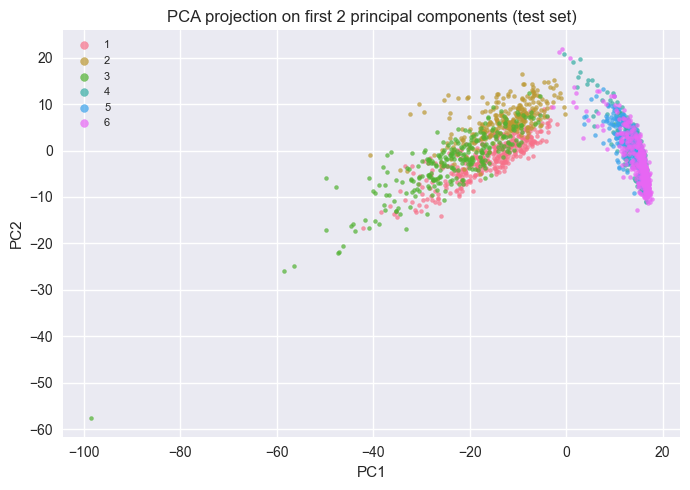

In [452]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 5))

labels = np.unique(y_test)

for lab in labels:
    idx = (y_test == lab)
    plt.scatter(
        T_test_np[idx, 0],
        T_test_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (test set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


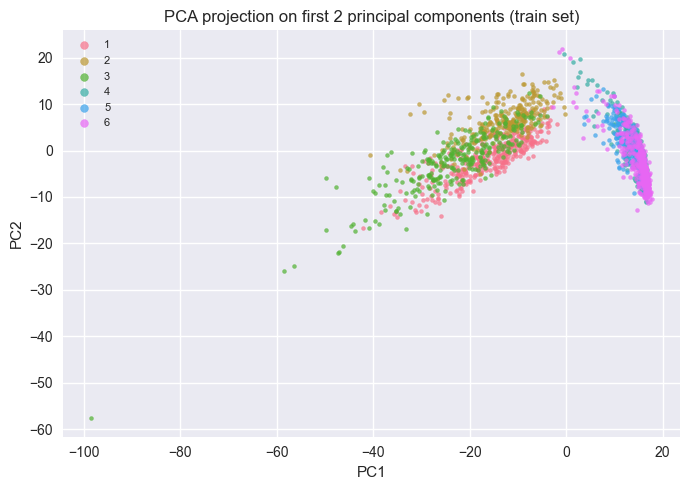

In [453]:
plt.figure(figsize=(7, 5))

labels = np.unique(y_test)

for lab in labels:
    idx = (y_test == lab)
    plt.scatter(
        T_test_np[idx, 0],
        T_test_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


In [454]:
from sklearn.decomposition import PCA as SK_PCA

sklearn_pca = SK_PCA(n_components=2)
sklearn_pca.fit(X_train)


PCA(n_components=2)

In [455]:
print(sklearn_pca.explained_variance_ratio_)

[0.5075262  0.06258965]


In [456]:
T_train = sklearn_pca.transform(X_train)
T_test = sklearn_pca.transform(X_test)


In [457]:
T_train_np = np.asarray(T_train)
y_train_np = np.asarray(y_train)

T_test_np = np.asarray(T_test)
y_test_np = np.asarray(y_test)

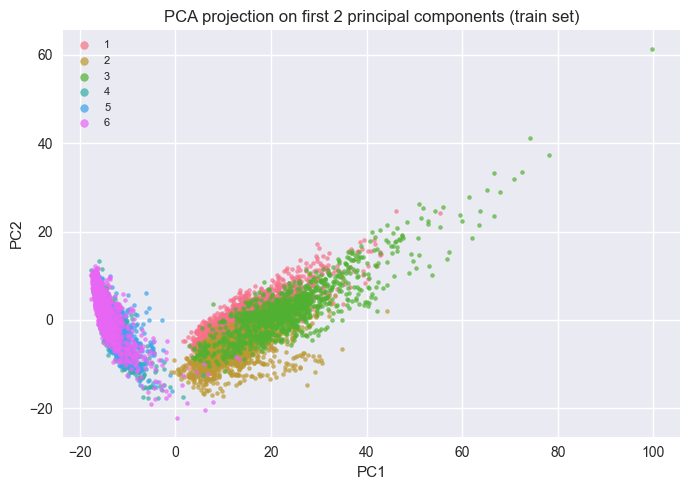

In [458]:
plt.figure(figsize=(7, 5))

labels = np.unique(y_train)

for lab in labels:
    idx = (y_train== lab)
    plt.scatter(
        T_train_np[idx, 0],
        T_train_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()

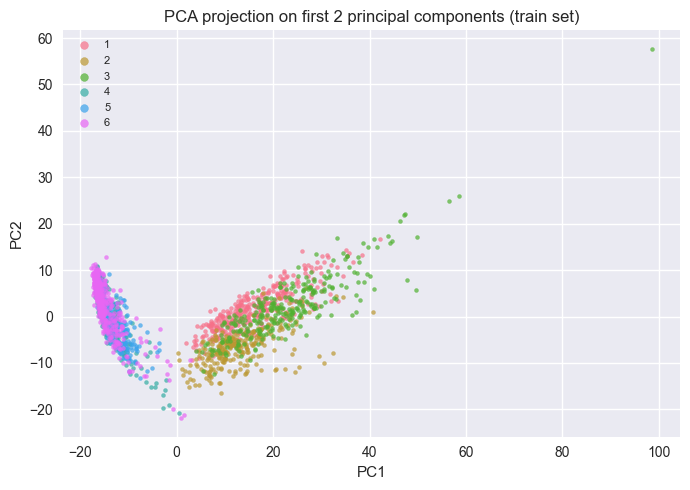

In [459]:
plt.figure(figsize=(7, 5))

labels = np.unique(y_test)

for lab in labels:
    idx = (y_test == lab)
    plt.scatter(
        T_test_np[idx, 0],
        T_test_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


## Least Squares Classifier

In [460]:
class LeastSquaresClassifier(BaseModel):

    def __init__(self, lam=1e-2, add_bias=True):
        self.lam = lam
        self.add_bias = add_bias
        self.W = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        Y, _ = make_one_hot(y, self.classes)

        if self.add_bias:
            X = np.c_[np.ones((X.shape[0], 1)), X]

        d = X.shape[1]
        A = X.T @ X + self.lam * np.eye(d)
        B = X.T @ Y

        self.W = np.linalg.solve(A, B)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if self.add_bias:
            X = np.c_[np.ones((X.shape[0], 1)), X]

        scores = X @ self.W
        pred_idx = np.argmax(scores, axis=1)
        return self.classes[pred_idx]


In [461]:
model = LeastSquaresClassifier(lam=1e-2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("\nClassification Report:")
print_classification_report(y_test, y_pred)

Test Accuracy: 0.9752427184466019

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9853       0.9963       0.9908       270         
3               1.0000       0.9965       0.9982       284         
4               0.9434       0.9284       0.9358       377         
5               0.9380       0.9407       0.9394       354         
6               0.9927       1.0000       0.9963       406         
-----------------------------------------------------------------
macro avg       0.9761       0.9765       0.9763       2060        
weighted avg    0.9751       0.9752       0.9752       2060        
-----------------------------------------------------------------
accuracy        0.9752       2060        



In [462]:
from sklearn.linear_model import RidgeClassifier as SK_RidgeClassifier

clf = SK_RidgeClassifier(alpha=1e-2)
fit_sklearn_model(clf, X_train, y_train, X_test, y_test)

Test Accuracy: 0.9752427184466019

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9853       0.9963       0.9908       270         
3               1.0000       0.9965       0.9982       284         
4               0.9434       0.9284       0.9358       377         
5               0.9380       0.9407       0.9394       354         
6               0.9927       1.0000       0.9963       406         
-----------------------------------------------------------------
macro avg       0.9761       0.9765       0.9763       2060        
weighted avg    0.9751       0.9752       0.9752       2060        
-----------------------------------------------------------------
accuracy        0.9752       2060        



In [463]:
acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("\nClassification Report:")
print_classification_report(y_test, y_pred)

Test Accuracy: 0.9752427184466019

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9853       0.9963       0.9908       270         
3               1.0000       0.9965       0.9982       284         
4               0.9434       0.9284       0.9358       377         
5               0.9380       0.9407       0.9394       354         
6               0.9927       1.0000       0.9963       406         
-----------------------------------------------------------------
macro avg       0.9761       0.9765       0.9763       2060        
weighted avg    0.9751       0.9752       0.9752       2060        
-----------------------------------------------------------------
accuracy        0.9752       2060        



## Softmax Logistic Regression

In [464]:
def one_hot_from_indices(y_idx: np.ndarray, C: int) -> np.ndarray:
    Y = np.zeros((y_idx.size, C), dtype=float)
    Y[np.arange(y_idx.size), y_idx] = 1.0
    return Y


class LogisticRegression(BaseModel):

    def __init__(self, lr=0.05, epochs=20, batch_size=128, lam=0.0, seed=42):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lam = lam
        self.seed = seed
        self.W = None
        self.b = None
        self.classes = None
        self.history = None



    def fit(self, X_train, y_train, X_test, y_test):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        C = self.classes.size
        class_to_idx = {c: i for i, c in enumerate(self.classes)}
        y_idx = np.array([class_to_idx[v] for v in y], dtype=int)

        X_test_arr = np.asarray(X_test, dtype=float)
        y_test_arr = np.asarray(y_test)
        y_test_idx = np.array([class_to_idx[v] for v in y_test_arr], dtype=int)
        Y_test = one_hot_from_indices(y_test_idx, C)

        n, d = X.shape
        rng = np.random.default_rng(self.seed)

        self.W = rng.normal(loc=0.0, scale=0.01, size=(C, d))
        self.b = np.zeros(C, dtype=float)

        self.history = {"loss": [], "test_loss": []}

        for epoch in range(1, self.epochs + 1):
            perm = rng.permutation(n)
            Xs = X[perm]
            ys = y_idx[perm]

            epoch_loss = 0.0
            n_batches = 0

            for start in range(0, n, self.batch_size):
                end = min(start + self.batch_size, n)
                Xb = Xs[start:end]
                yb = ys[start:end]
                Yb = one_hot_from_indices(yb, C)

                Z = Xb @ self.W.T + self.b
                P = softmax(Z)

                batch_loss = cross_entropy(P, Yb)
                epoch_loss += batch_loss
                n_batches += 1

                B = Xb.shape[0]
                G = (P - Yb) / B
                dW = G.T @ Xb
                db = G.sum(axis=0)

                if self.lam > 0:
                    dW += self.lam * self.W

                self.W -= self.lr * dW
                self.b -= self.lr * db

            self.history["loss"].append(epoch_loss / n_batches)

            Z_test = X_test_arr @ self.W.T + self.b
            P_test = softmax(Z_test)
            test_loss = cross_entropy(P_test, Y_test)
            self.history["test_loss"].append(test_loss)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        P = softmax(X @ self.W.T + self.b)
        pred_idx = np.argmax(P, axis=1)
        return self.classes[pred_idx]


Test Accuracy: 0.9694174757281553
Last train loss: 0.07568248883209706
Last test loss: 0.09099516924947283

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9919       0.9919       0.9919       369         
2               0.9851       0.9815       0.9833       270         
3               0.9825       0.9894       0.9860       284         
4               0.9288       0.9337       0.9312       377         
5               0.9343       0.9237       0.9290       354         
6               0.9975       1.0000       0.9988       406         
-----------------------------------------------------------------
macro avg       0.9700       0.9700       0.9700       2060        
weighted avg    0.9694       0.9694       0.9694       2060        
-----------------------------------------------------------------
accuracy        0.9694       2060        



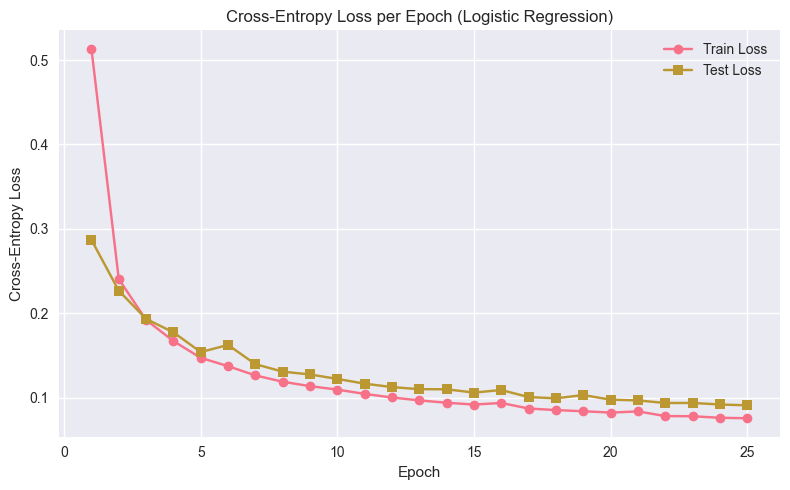

In [465]:
model = LogisticRegression(lr=0.05, epochs=25, batch_size=256, lam=1e-4)
model.fit(X_train, y_train, X_test, y_test)

y_pred = model.predict(X_test)

acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("Last train loss:", model.history["loss"][-1])
print("Last test loss:", model.history["test_loss"][-1])
print("\nClassification Report:")
print_classification_report(y_test, y_pred)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
epochs = range(1, len(model.history["loss"]) + 1)
plt.plot(epochs, model.history["loss"], label="Train Loss", marker="o")
plt.plot(epochs, model.history["test_loss"], label="Test Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Cross-Entropy Loss per Epoch (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [466]:
from sklearn.linear_model import LogisticRegression as SK_LogisticRegression
fit_sklearn_model(SK_LogisticRegression(penalty="l2", max_iter=25), X_train, y_train, X_test, y_test)

Test Accuracy: 0.9742718446601941

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9919       0.9919       0.9919       369         
2               0.9888       0.9852       0.9870       270         
3               0.9860       0.9894       0.9877       284         
4               0.9441       0.9416       0.9429       377         
5               0.9380       0.9407       0.9394       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9748       0.9748       0.9748       2060        
weighted avg    0.9743       0.9743       0.9743       2060        
-----------------------------------------------------------------
accuracy        0.9743       2060        



d:\Users\anast\AppData\Local\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## KNN

In [467]:
class KNNClassifier(BaseModel):

    def __init__(self, k=1):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = np.asarray(X_train, dtype=float)
        self.y_train = np.asarray(y_train)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        k = int(self.k)
        if k < 1 or k > self.X_train.shape[0]:
            raise ValueError("k must be in [1, n_train]")

        te_norm = np.sum(X**2, axis=1, keepdims=True)
        tr_norm = np.sum(self.X_train**2, axis=1, keepdims=True).T
        d2 = te_norm + tr_norm - 2 * (X @ self.X_train.T)
        d2 = np.maximum(d2, 0.0)

        nn_idx = np.argpartition(d2, kth=k-1, axis=1)[:, :k]

        y_pred = []
        for i in range(nn_idx.shape[0]):
            neigh_labels = self.y_train[nn_idx[i]]
            values, counts = np.unique(neigh_labels, return_counts=True)
            y_pred.append(values[np.argmax(counts)])

        return np.array(y_pred, dtype=self.y_train.dtype)


In [468]:
results = []

for k in range(1, 11):
    model = KNNClassifier(k=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = (y_pred == np.asarray(y_test)).mean()
    results.append((k, acc))
    print(f"k={k:2d} | accuracy={acc:.4f}")

best_k, best_acc = max(results, key=lambda t: t[1])
print(f"\nBest k in [1,10]: {best_k} (accuracy={best_acc:.4f})")

print("\nClassification Report for Best KNN (k={}):".format(best_k))
best_knn_model = KNNClassifier(k=best_k)
best_knn_model.fit(X_train, y_train)
best_knn_pred = best_knn_model.predict(X_test)
print_classification_report(y_test, best_knn_pred)


k= 1 | accuracy=0.9631
k= 2 | accuracy=0.9451
k= 3 | accuracy=0.9587
k= 4 | accuracy=0.9568
k= 5 | accuracy=0.9597
k= 6 | accuracy=0.9534
k= 7 | accuracy=0.9553
k= 8 | accuracy=0.9553
k= 9 | accuracy=0.9524
k=10 | accuracy=0.9519

Best k in [1,10]: 1 (accuracy=0.9631)

Classification Report for Best KNN (k=1):
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9892       0.9946       0.9919       369         
2               0.9889       0.9889       0.9889       270         
3               0.9894       0.9824       0.9859       284         
4               0.9311       0.8966       0.9135       377         
5               0.8898       0.9350       0.9118       354         
6               1.0000       0.9901       0.9950       406         
-----------------------------------------------------------------
macro avg       0.9647       0.9646       0.9645       2060        
weighted avg

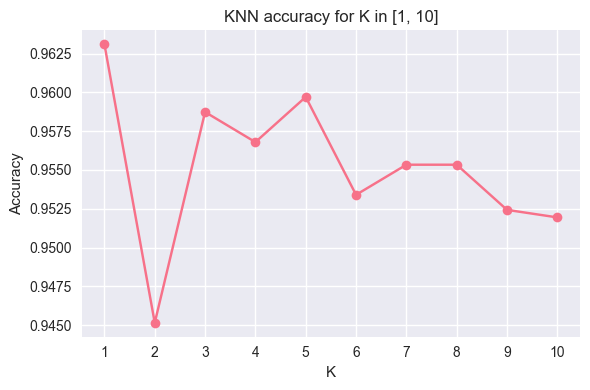

In [469]:
import matplotlib.pyplot as plt

ks = [k for k, _ in results]
accs = [a for _, a in results]

plt.figure(figsize=(6,4))
plt.plot(ks, accs, marker="o")
plt.xticks(ks)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN accuracy for K in [1, 10]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [470]:
from sklearn.neighbors import KNeighborsClassifier as SK_KNeighborsClassifier
fit_sklearn_model(SK_KNeighborsClassifier(n_neighbors=best_k), X_train, y_train, X_test, y_test)

Test Accuracy: 0.9631067961165048

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9892       0.9946       0.9919       369         
2               0.9889       0.9889       0.9889       270         
3               0.9894       0.9824       0.9859       284         
4               0.9311       0.8966       0.9135       377         
5               0.8898       0.9350       0.9118       354         
6               1.0000       0.9901       0.9950       406         
-----------------------------------------------------------------
macro avg       0.9647       0.9646       0.9645       2060        
weighted avg    0.9636       0.9631       0.9632       2060        
-----------------------------------------------------------------
accuracy        0.9631       2060        



## Gaussian Naive Bayes Classifier


In [471]:
class GaussianNaiveBayes(BaseModel):

    def __init__(self, eps=1e-9):
        self.eps = eps
        self.priors = None
        self.means = None
        self.class_variances = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        C = self.classes.size
        n, d = X.shape

        self.priors = np.zeros(C, dtype=float)
        self.means = np.zeros((C, d), dtype=float)
        self.class_variances = np.zeros((C, d), dtype=float)

        for i, c in enumerate(self.classes):
            Xc = X[y == c]
            self.priors[i] = Xc.shape[0] / n
            self.means[i] = Xc.mean(axis=0)
            self.class_variances[i] = Xc.var(axis=0, ddof=0) + self.eps

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        m, d = X.shape
        C = self.classes.size

        log_priors = np.log(self.priors)

        X3 = X[:, None, :]
        mu = self.means[None, :, :]
        va = self.class_variances[None, :, :]

        log_det_term = -0.5 * np.sum(np.log(2.0 * np.pi * va), axis=2)
        quad_term = -0.5 * np.sum(((X3 - mu) ** 2) / va, axis=2)

        log_post = log_det_term + quad_term + log_priors[None, :]

        pred_idx = np.argmax(log_post, axis=1)
        return self.classes[pred_idx]


In [472]:
model = GaussianNaiveBayes(eps=1e-9)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("\nClassification Report:")
print_classification_report(y_test, y_pred)


Test Accuracy: 0.746116504854369

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9303       0.7236       0.8140       369         
2               0.6568       0.9074       0.7621       270         
3               0.7614       0.7641       0.7627       284         
4               0.5489       0.8939       0.6801       377         
5               0.8138       0.3333       0.4729       354         
6               0.9916       0.8695       0.9265       406         
-----------------------------------------------------------------
macro avg       0.7838       0.7486       0.7364       2060        
weighted avg    0.7934       0.7461       0.7392       2060        
-----------------------------------------------------------------
accuracy        0.7461       2060        



In [473]:
from sklearn.naive_bayes import GaussianNB as SK_GaussianNB
fit_sklearn_model(SK_GaussianNB(), X_train, y_train, X_test, y_test)

Test Accuracy: 0.746116504854369

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9303       0.7236       0.8140       369         
2               0.6568       0.9074       0.7621       270         
3               0.7614       0.7641       0.7627       284         
4               0.5489       0.8939       0.6801       377         
5               0.8138       0.3333       0.4729       354         
6               0.9916       0.8695       0.9265       406         
-----------------------------------------------------------------
macro avg       0.7838       0.7486       0.7364       2060        
weighted avg    0.7934       0.7461       0.7392       2060        
-----------------------------------------------------------------
accuracy        0.7461       2060        



# MLP

In [474]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


class TorchMLP(BaseModel):
    def __init__(
        self,
        hidden_sizes=(256, 128),
        activation="relu",
        lr=0.05,
        momentum=0.9,
        batch_size=128,
        epochs=100,
        seed=42,
        device="cpu"
    ):
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.lr = lr
        self.momentum = momentum
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.device = device

        self.model_ = None
        self.classes_ = None

        self.train_loss_ = []
        self.train_acc_ = []
        self.test_loss_ = []
        self.test_acc_ = []

    def _build_network(self, in_features: int, num_classes: int) -> nn.Module:
        if self.activation.lower() == "relu":
            act = nn.ReLU
        elif self.activation.lower() == "tanh":
            act = nn.Tanh
        elif self.activation.lower() == "gelu":
            act = nn.GELU
        else:
            raise ValueError("activation must be one of: relu, tanh, gelu")

        layers = []
        prev = in_features
        for h in self.hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(act())
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        return nn.Sequential(*layers)

    @torch.no_grad()
    def _eval_loader(self, loader, loss_fn):
        self.model_.eval()
        loss_sum, correct, total = 0.0, 0, 0

        for xb, yb in loader:
            xb, yb = xb.to(self.device), yb.to(self.device)
            logits = self.model_(xb)
            loss = loss_fn(logits, yb)

            loss_sum += loss.item() * xb.size(0)
            correct += (logits.argmax(dim=1) == yb).sum().item()
            total += xb.size(0)

        return loss_sum / total, correct / total

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        torch.manual_seed(self.seed)


        Xtr_np = np.asarray(X_train, dtype=np.float32)
        ytr_np = np.asarray(y_train)

        self.classes_ = np.unique(ytr_np)
        _, ytr_idx = make_one_hot(ytr_np, self.classes_)

        Xtr = torch.from_numpy(Xtr_np).float()
        ytr = torch.from_numpy(ytr_idx).long()

        train_loader = DataLoader(
            TensorDataset(Xtr, ytr),
            batch_size=self.batch_size,
            shuffle=True
        )

        test_loader = None
        if X_test is not None and y_test is not None:
            Xte_np = np.asarray(X_test, dtype=np.float32)
            yte_np = np.asarray(y_test)
            _, yte_idx = make_one_hot(yte_np, self.classes_)  # same classes mapping

            Xte = torch.from_numpy(Xte_np).float()
            yte = torch.from_numpy(yte_idx).long()

            test_loader = DataLoader(
                TensorDataset(Xte, yte),
                batch_size=256,
                shuffle=False
            )

        # model / loss / optimizer
        in_features = Xtr.shape[1]
        num_classes = len(self.classes_)

        self.model_ = self._build_network(in_features, num_classes).to(self.device)

        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model_.parameters(), lr=self.lr, momentum=self.momentum)

        # training loop
        self.train_loss_.clear()
        self.train_acc_.clear()
        self.test_loss_.clear()
        self.test_acc_.clear()

        for epoch in range(1, self.epochs + 1):
            self.model_.train()
            loss_sum, correct, total = 0.0, 0, 0

            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)

                optimizer.zero_grad()
                logits = self.model_(xb)
                loss = loss_fn(logits, yb)
                loss.backward()
                optimizer.step()

                loss_sum += loss.item() * xb.size(0)
                correct += (logits.argmax(dim=1) == yb).sum().item()
                total += xb.size(0)

            tr_loss = loss_sum / total
            tr_acc = correct / total
            self.train_loss_.append(tr_loss)
            self.train_acc_.append(tr_acc)

            if test_loader is not None:
                te_loss, te_acc = self._eval_loader(test_loader, loss_fn)
                self.test_loss_.append(te_loss)
                self.test_acc_.append(te_acc)

                if epoch == 1 or epoch % 10 == 0:
                    print(f"Epoch {epoch:03d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")
            else:
                if epoch == 1 or epoch % 10 == 0:
                    print(f"Epoch {epoch:03d} | train loss {tr_loss:.4f} acc {tr_acc:.4f}")

        return self

    @torch.no_grad()
    def predict(self, X):
        X_np = np.asarray(X, dtype=np.float32)
        X_tensor = torch.from_numpy(X_np).float().to(self.device)

        self.model_.eval()
        pred_idx = self.model_(X_tensor).argmax(dim=1).cpu().numpy()
        return self.classes_[pred_idx]


In [475]:
mlp = TorchMLP(
    hidden_sizes=(256, 128),
    activation="relu",
    lr=0.05,
    momentum=0.9,
    batch_size=128,
    epochs=100
)

mlp.fit(X_train, y_train, X_test, y_test)
y_pred = mlp.predict(X_test)

print_classification_report(y_test, y_pred, labels=np.unique(y_train))

Epoch 001 | train loss 0.4942 acc 0.8011 | test loss 0.1230 acc 0.9534
Epoch 010 | train loss 0.0193 acc 0.9924 | test loss 0.0534 acc 0.9762
Epoch 020 | train loss 0.0083 acc 0.9975 | test loss 0.0487 acc 0.9825
Epoch 030 | train loss 0.0002 acc 1.0000 | test loss 0.0466 acc 0.9864
Epoch 040 | train loss 0.0001 acc 1.0000 | test loss 0.0491 acc 0.9869
Epoch 050 | train loss 0.0001 acc 1.0000 | test loss 0.0501 acc 0.9864
Epoch 060 | train loss 0.0001 acc 1.0000 | test loss 0.0511 acc 0.9864
Epoch 070 | train loss 0.0000 acc 1.0000 | test loss 0.0519 acc 0.9864
Epoch 080 | train loss 0.0000 acc 1.0000 | test loss 0.0525 acc 0.9864
Epoch 090 | train loss 0.0000 acc 1.0000 | test loss 0.0533 acc 0.9874
Epoch 100 | train loss 0.0000 acc 1.0000 | test loss 0.0538 acc 0.9874
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               1.0000       0.9946       0.9973       369         
2               0

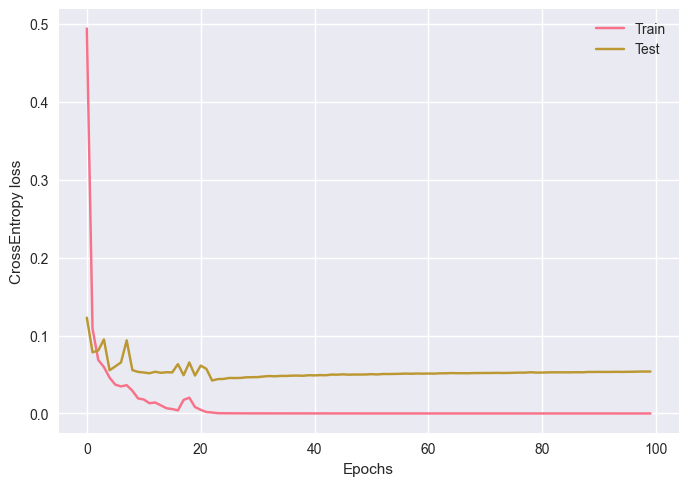

In [476]:
import matplotlib.pyplot as plt

plt.plot(mlp.train_loss_, label="Train")
if len(mlp.test_loss_) > 0:
    plt.plot(mlp.test_loss_, label="Test")
plt.xlabel("Epochs")
plt.ylabel("CrossEntropy loss")
plt.legend()
plt.show()


In [477]:
from sklearn.neural_network import MLPClassifier as SK_MLPClassifier

clf = SK_MLPClassifier(hidden_layer_sizes=(256, 128), activation="relu", max_iter=100, alpha=0.0001, batch_size=128, learning_rate_init=0.005, solver='adam', momentum=0.9,random_state=42)
fit_sklearn_model(clf, X_train, y_train, X_test, y_test)

Test Accuracy: 0.9844660194174757

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9946       0.9959       369         
2               0.9853       0.9926       0.9889       270         
3               0.9894       0.9894       0.9894       284         
4               0.9632       0.9708       0.9670       377         
5               0.9714       0.9605       0.9659       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9844       0.9846       0.9845       2060        
weighted avg    0.9845       0.9845       0.9845       2060        
-----------------------------------------------------------------
accuracy        0.9845       2060        



## One-vs-Rest SVM (OVR-SVM)

In the lab, the problem was binary classification. Here we use the One-vs-Rest approach:
- We train one SVM for each class
- For each SVM, the positive class is the active class (+1) and all others are negative (-1)
- The final label is the label of the SVM with the highest score

In [478]:
class SVM(BaseModel):

    def __init__(self, lr=0.01, epochs=10, lam=1e-4, seed=42):
        self.lr = lr
        self.epochs = epochs
        self.lam = lam
        self.seed = seed
        self.W = None
        self.b = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        Ws = []
        bs = []

        for idx, c in enumerate(self.classes):
            y_pm1 = np.where(y == c, 1.0, -1.0)
            w, b = self._fit_linear_svm_sgd(X, y_pm1, seed=self.seed + idx)
            Ws.append(w)
            bs.append(b)

        self.W = np.vstack(Ws)
        self.b = np.array(bs, dtype=float)
        return self

    def _fit_linear_svm_sgd(self, X, y_pm1, seed):
        n, d = X.shape
        rng = np.random.default_rng(seed)
        w = np.zeros(d, dtype=float)
        b = 0.0

        for epoch in range(self.epochs):
            perm = rng.permutation(n)
            for i in perm:
                xi = X[i]
                yi = y_pm1[i]
                margin = yi * (xi @ w + b)

                if margin >= 1.0:
                    w -= self.lr * (self.lam * w)
                else:
                    w -= self.lr * (self.lam * w - yi * xi)
                    b -= self.lr * (-yi)

        return w, b

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        scores = X @ self.W.T + self.b
        pred_idx = np.argmax(scores, axis=1)
        return self.classes[pred_idx]


In [479]:
model = SVM(lr=0.01, epochs=10, lam=1e-4, seed=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = (y_pred == np.asarray(y_test)).mean()
print("Test Accuracy:", acc)
print("\nClassification Report:")
print_classification_report(y_test, y_pred)


Test Accuracy: 0.962135922330097

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9946       1.0000       0.9973       369         
2               0.9926       0.9889       0.9907       270         
3               0.9965       0.9965       0.9965       284         
4               0.8451       0.9841       0.9093       377         
5               0.9828       0.8079       0.8868       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9686       0.9629       0.9634       2060        
weighted avg    0.9663       0.9621       0.9618       2060        
-----------------------------------------------------------------
accuracy        0.9621       2060        



In [480]:
from sklearn.svm import LinearSVC as SK_LinearSVC
fit_sklearn_model(SK_LinearSVC(C=1e-2), X_train, y_train, X_test, y_test)

Test Accuracy: 0.9810679611650486

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9926       0.9963       0.9945       270         
3               0.9965       1.0000       0.9982       284         
4               0.9521       0.9496       0.9509       377         
5               0.9518       0.9492       0.9505       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9817       0.9821       0.9819       2060        
weighted avg    0.9810       0.9811       0.9810       2060        
-----------------------------------------------------------------
accuracy        0.9811       2060        



## K-Means Clustering

In [481]:
class KMeans(BaseModel):

    def __init__(self, k, max_iters=100, seed=42):
        self.k = k
        self.max_iters = max_iters
        self.seed = seed
        self.centroids = None

    def fit(self, X_train, y_train=None):
        X = np.asarray(X_train, dtype=float)
        n, d = X.shape
        rng = np.random.default_rng(self.seed)

        idx = rng.choice(n, size=self.k, replace=False)
        self.centroids = X[idx].copy()

        labels = np.zeros(n, dtype=int)

        for it in range(self.max_iters):
            x_norm = np.sum(X**2, axis=1, keepdims=True)
            c_norm = np.sum(self.centroids**2, axis=1, keepdims=True).T
            d2 = x_norm + c_norm - 2 * (X @ self.centroids.T)
            d2 = np.maximum(d2, 0.0)

            new_labels = np.argmin(d2, axis=1)

            if np.array_equal(new_labels, labels) and it > 0:
                break
            labels = new_labels

            for j in range(self.k):
                pts = X[labels == j]
                if pts.shape[0] > 0:
                    self.centroids[j] = pts.mean(axis=0)
                else:
                    self.centroids[j] = X[rng.integers(0, n)]

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        x_norm = np.sum(X**2, axis=1, keepdims=True)
        c_norm = np.sum(self.centroids**2, axis=1, keepdims=True).T
        d2 = x_norm + c_norm - 2 * (X @ self.centroids.T)
        d2 = np.maximum(d2, 0.0)

        return np.argmin(d2, axis=1)


Number of clusters: 6
Clusters found: [0 1 2 3 4 5]
Explained variance (PC1+PC2): 319.874


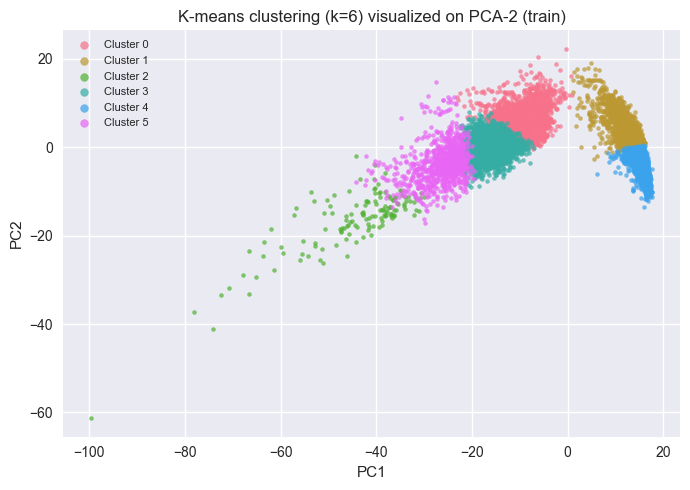

In [482]:
k_clusters = len(np.unique(y_train))
model = KMeans(k=k_clusters, max_iters=100, seed=42)
model.fit(X_train, y_train=None)

clabels = model.predict(X_train)

pca2 = PCA(n_components=2)
pca2.fit(X_train)
Ttr2 = pca2.predict(X_train)
Ttr2_np = np.asarray(Ttr2)

print(f"Number of clusters: {k_clusters}")
print(f"Clusters found: {np.unique(clabels)}")
print(f"Explained variance (PC1+PC2): {pca2.explained_variance_.sum():.3f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for c in range(k_clusters):
    idx = (clabels == c)
    plt.scatter(Ttr2_np[idx, 0], Ttr2_np[idx, 1], s=8, alpha=0.7, label=f"Cluster {c}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-means clustering (k={k_clusters}) visualized on PCA-2 (train)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


Number of clusters: 6
Clusters found: [0 1 2 3 4 5]
Explained variance (PC1+PC2): 319.874


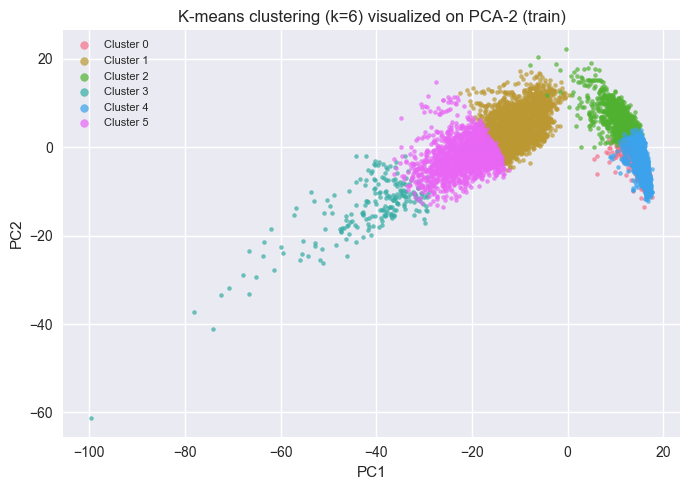

In [483]:
from sklearn.cluster import KMeans as SK_KMeans

model = SK_KMeans(n_clusters=k_clusters, max_iter=100, random_state=42)
model.fit(X_train)

clabels = model.predict(X_train)

pca2 = PCA(n_components=2)
pca2.fit(X_train)
Ttr2 = pca2.predict(X_train)
Ttr2_np = np.asarray(Ttr2)

print(f"Number of clusters: {k_clusters}")
print(f"Clusters found: {np.unique(clabels)}")
print(f"Explained variance (PC1+PC2): {pca2.explained_variance_.sum():.3f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for c in range(k_clusters):
    idx = (clabels == c)
    plt.scatter(Ttr2_np[idx, 0], Ttr2_np[idx, 1], s=8, alpha=0.7, label=f"Cluster {c}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-means clustering (k={k_clusters}) visualized on PCA-2 (train)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


## Σχόλια εκφώνησης / αξιολόγησης

- Logistic Regression: έχεις loss per epoch (good), αλλά δεν δείχνεις καθαρά train accuracy ανά epoch (ή έστω τελικό train acc). Η εκφώνηση το ζητάει ρητά μαζί με τα loss plots.
- Η εκφώνηση ζητάει train και test accuracy για κάθε μέθοδο. Στο notebook σου, σε αρκετά σημεία τυπώνεις μόνο "Test Accuracy" (Least Squares, Logistic, Naive Bayes, κ.ά.). Αυτό είναι κλασική "εύκολη" αφαίρεση μονάδων γιατί είναι ρητή απαίτηση.